In [1]:
import os, sys

from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pandas import DataFrame

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from data_manager import *
from metadata import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for AWS compute node


No vtk
File does not exist: /shared/CSHL_data_processed/MD635/MD635_anchor.txt
File does not exist: /shared/CSHL_data_processed/MD635/MD635_sorted_filenames.txt
File does not exist: /shared/CSHL_data_processed/MD635/MD635_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD635/MD635_cropbox.txt


In [2]:
stack = 'MD658'
_, sec2fn = DataManager.load_sorted_filenames(stack)
first_sec, last_sec = DataManager.load_cropbox(stack)[4:]

# Match histograms between Nissl and Neurotrace

In [3]:
def hist_match(source, template):
    """
    Adjust the pixel values of a grayscale image such that its histogram
    matches that of a target image

    Arguments:
    -----------
        source: np.ndarray
            Image to transform; the histogram is computed over the flattened
            array
        template: np.ndarray
            Template image; can have different dimensions to source
    Returns:
    -----------
        matched: np.ndarray
            The transformed output image
    """
    # http://stackoverflow.com/a/33047048

    oldshape = source.shape
    source = source.ravel()
    template = template.ravel()

    # get the set of unique pixel values and their corresponding indices and
    # counts
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True,
                                            return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)

    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    # interpolate linearly to find the pixel values in the template image
    # that correspond most closely to the quantiles in the source image
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)

    return interp_t_values[bin_idx].reshape(oldshape)

In [55]:
nissl_sections = [sec for sec, fn in sec2fn.iteritems() if not is_invalid(fn) and fn.split('-')[1][0] == 'N' and sec > first_sec and sec < last_sec]
ntb_sections = [sec for sec, fn in sec2fn.iteritems() if not is_invalid(fn) and fn.split('-')[1][0] == 'F' and sec > first_sec and sec < last_sec]

In [58]:
compare_pairs = []
for nissl_sec in nissl_sections:
    for i in range(1, 10):
        closest_ntb_sec = nissl_sec + i
        if closest_ntb_sec in ntb_sections:
            break
    compare_pairs.append((nissl_sec, closest_ntb_sec))

In [20]:
w, h = metadata_cache['image_shape'][stack]

In [103]:
region1_x = np.random.randint(0, w-10000, 1)[0]
region1_y = np.random.randint(0, h-10000, 1)[0]
region1_w = 5000
region1_h = 5000
print region1_x, region1_y, region1_w, region1_h

6239 5651 5000 5000


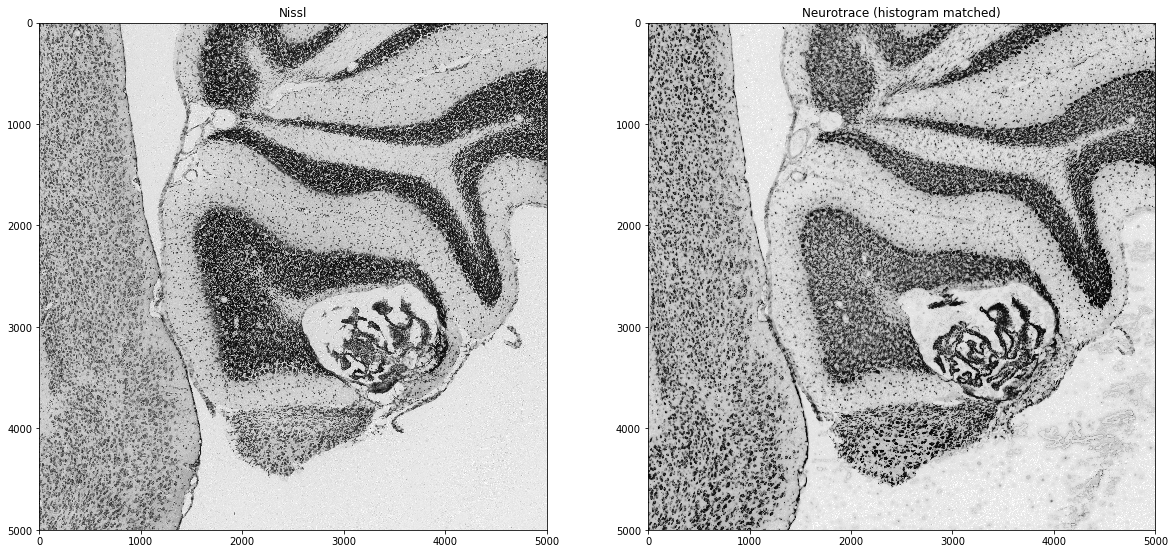

In [ ]:
ntb_matched_values_all_examples = []

for nissl_sec, ntb_sec in compare_pairs[::10]:
    
    ntb_im_fp = DataManager.get_image_filepath(stack=stack, section=ntb_sec, version='cropped_16bit', resol='lossless')
    download_from_s3(ntb_im_fp)
    ntb_im = imread(ntb_im_fp)
    ntb_blue_region1 = ntb_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w, 2]
    ntb_blue_region1 = 3000 - ntb_blue_region1
    
    ntb_blue_bins = np.arange(0, ntb_blue_region1.max()+2)
    ntb_blue_hist = np.histogram(ntb_blue_region1.flatten(), bins=ntb_blue_bins)[0]
    
    nissl_im_fp = DataManager.get_image_filepath(stack=stack, section=nissl_sec, version='cropped_8bit', resol='lossless')
    download_from_s3(nissl_im_fp)
    nissl_im = imread(nissl_im_fp)
    nissl_region1 = img_as_ubyte(rgb2gray(nissl_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w]))
    
    nissl_gray_bins = np.arange(0, 257)
    nissl_gray_hist = np.histogram(nissl_region1.flatten(), bins=nissl_gray_bins)[0]
    
    ###############
    
    ntb_region1_hist_matched = hist_match(ntb_blue_region1, nissl_region1)
    
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20,10));
    axes[0].imshow(nissl_region1, plt.cm.gray);
    axes[0].set_title('Nissl');
    axes[1].imshow(ntb_region1_hist_matched.astype(np.uint8), plt.cm.gray);
    axes[1].set_title('Neurotrace (histogram matched)');
    plt.show();
    
    ntb_to_nissl = {}
    for ntb_v in ntb_blue_bins[:-1]:
        a = ntb_region1_hist_matched[ntb_blue_region1 == ntb_v]
        if len(a) > 0:
            ntb_to_nissl[ntb_v] = np.unique(a)[0]

    ntb_values = np.arange(0, 5000)
    ntb_matched_values = np.interp(ntb_values, 
                                   [ntb_v for ntb_v, nissl_v in sorted(ntb_to_nissl.items())], 
                                   [nissl_v for ntb_v, nissl_v in sorted(ntb_to_nissl.items())])
    
    ntb_matched_values_all_examples.append(ntb_matched_values)

    plt.plot(ntb_values, ntb_matched_values);
    plt.xlim([0,5000]);
    plt.ylim([0,256]);
    plt.xlabel('Neurotrace intensity');
    plt.ylabel('Matched nissl intensity');
    plt.show();

In [ ]:
plt.figure(figsize=(10,5));
for a in ntb_matched_values_all_examples:
    plt.plot(ntb_values, a);
plt.xlim([0,5000]);
plt.ylim([0,256]);
plt.xlabel('Neurotrace intensity');
plt.ylabel('Matched nissl intensity');
plt.show();

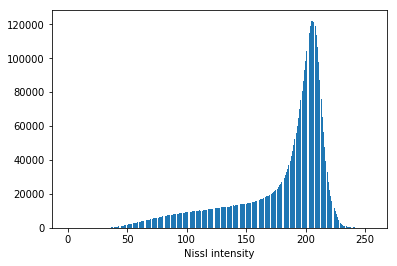

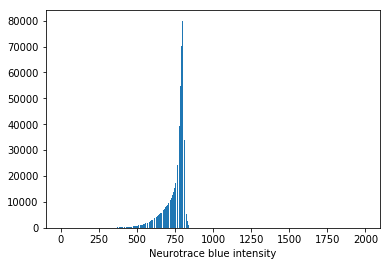

In [65]:
plt.bar(nissl_gray_bins[:-1], nissl_gray_hist);
plt.xlabel('Nissl intensity');
plt.show();

plt.bar(ntb_blue_bins[:-1], ntb_blue_hist);
plt.xlabel('Neurotrace blue intensity');
plt.show();

# Whole-image histogram

In [ ]:
info = {}
for sec in range(first_sec, last_sec+1):
    print sec
    fn = sec2fn[sec]
#     im = imread('/home/yuncong/csd395/CSHL_data/MD657_lossy_tif/%s_lossy.jp2.tif' % fn)[..., :3]
    green = im[..., 1]
    gf = green.flatten()
    blue = im[..., 2]
    bf = blue.flatten()
    info[sec] = {'gmax': green.max(),
    'bmax': blue.max(),
    'g99.99': np.percentile(gf, 99.99),
    'g99.999': np.percentile(gf, 99.999),
    'g99.9999': np.percentile(gf, 99.9999),
    'b99.99': np.percentile(bf, 99.99),
    'b99.999': np.percentile(bf, 99.999),
    'b99.9999': np.percentile(bf, 99.9999)}

In [20]:
d = DataFrame(info).T

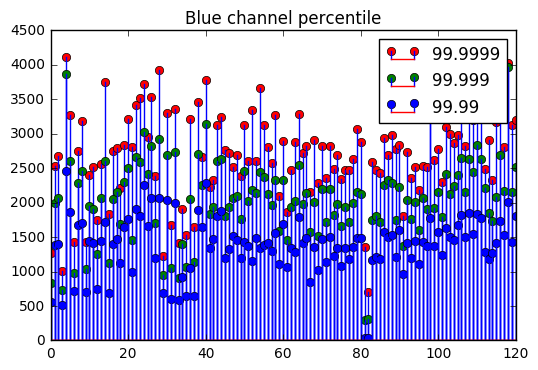

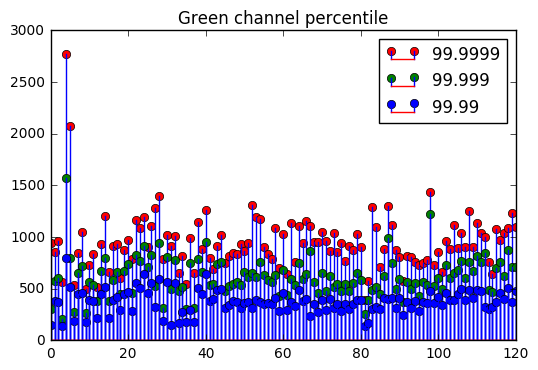

In [32]:
plt.figure();
plt.stem(d['b99.9999'], markerfmt='ro', label='99.9999');
plt.stem(d['b99.999'], markerfmt='go', label='99.999');
plt.stem(d['b99.99'], markerfmt='bo', label='99.99');
plt.title('Blue channel percentile');
plt.legend();

plt.figure();
plt.stem(d['g99.9999'], markerfmt='ro', label='99.9999');
plt.stem(d['g99.999'], markerfmt='go', label='99.999');
plt.stem(d['g99.99'], markerfmt='bo', label='99.99');
plt.title('Green channel percentile');
plt.legend();

# Contrast Stretch Neurotrace Blue

In [12]:
from skimage.exposure import rescale_intensity

In [80]:
red = im[..., 0]
green = im[..., 1]
blue = im[..., 2]

In [87]:
im.shape

(27265, 48265, 3)

In [ ]:
ys = range(1000, im.shape[0]-2000, 2000)
xs = range(1000, im.shape[1]-2000, 2000)

fig, axes = plt.subplots(int(np.ceil(len(ys)*len(xs)/5)), 5, sharex=True, sharey=True, figsize=(20, 10))
axes = axes.flatten()

c = 0
for yi, y in enumerate(ys):
    for xi, x in enumerate(xs):
        b = blue[y:y+1000,x:x+1000]
        count, left_edges = np.histogram(b.flatten(), bins=np.arange(b.min(), b.max()))
        axes[c].bar(left_edges[:-1], np.log(count), width=.1);
        c += 1
        
plt.show();

In [ ]:
ys = range(1000, im.shape[0]-2000, 2000)
xs = range(1000, im.shape[1]-2000, 2000)

fig, axes = plt.subplots(len(ys), len(xs), sharex=True, sharey=True, figsize=(20, 10))

for yi, y in enumerate(ys):
    for xi, x in enumerate(xs):
        b = blue[y:y+1000,x:x+1000]
        count, left_edges = np.histogram(b.flatten(), bins=np.arange(b.min(), b.max()))
        axes[yi][xi].bar(left_edges[:-1], np.log(count), width=.1);
        
plt.show();

In [50]:
im.shape

(14848, 27125, 3)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


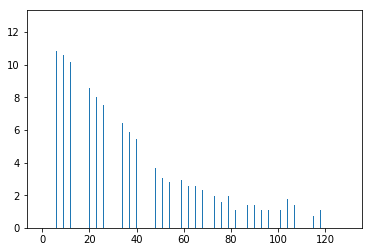

In [14]:
y = 7000
x = 13000
b = blue[y:y+1000,x:x+1000]
count, left_edges = np.histogram(b.flatten(), bins=np.arange(b.min(), b.max()))
plt.bar(left_edges[:-1], np.log(count), width=.1);
plt.show();

In [56]:
x = 27232
y = 14752
w = 3552
h = 2784

In [81]:
imin_red = 0
imax_red = 400

In [84]:
red_out = rescale_intensity(im[y:y+h, x:x+w], in_range=(imin_red, imax_red), out_range=np.uint8)

In [ ]:
im = imread(args.input_fp)[..., :3]
im_out = rescale_intensity(im, in_range=(args.imin, args.imax), out_range=np.uint8)
imsave(args.output_fp, im_out)

In [85]:
display_image(red_out)

/shared/MouseBrainAtlas/preprocess/tmp.jpg

In [76]:
imin_blue = 0
imax_blue = 400

400


In [77]:
blue_out = rescale_intensity(blue[y:y+h, x:x+w], in_range=(imin_blue, imax_blue), out_range=np.uint8)

In [78]:
display_image(blue_out)

/shared/MouseBrainAtlas/preprocess/tmp.jpg

In [67]:
imin_green = 0
imax_green = 400

400


In [68]:
green_out = rescale_intensity(green[y:y+h, x:x+w], in_range=(imin_green, imax_green), out_range=np.uint8)

In [69]:
display_image(green_out)

/shared/MouseBrainAtlas/preprocess/tmp.jpg

In [61]:
from skimage.exposure import adjust_gamma

In [62]:
blue_out_gamma = adjust_gamma(blue_out, .5)

In [63]:
display_image(blue_out_gamma[8000:11000, 8000:11000])

/oasis/projects/nsf/csd395/yuncong/Brain/preprocess/tmp.jpg

In [ ]:
for sec in range(first_sec, last_sec+1, 5):
# for sec in [132]: # example blue, random region
# for sec in [120]: # has good green
    
    print sec
    fn = sec2fn[sec]
    im = imread('/home/yuncong/csd395/CSHL_data/MD657_lossy_tif/%s_lossy.jp2.tif' % fn)[..., :3]
    
#     plt.figure();
#     count, left_edges = np.histogram(im[...,2].flatten(), bins=np.arange(im[...,2].min(), im[...,2].max()))
#     plt.bar(left_edges[:-1], np.log(count), width=.1);
#     plt.title('Log histogram before contrast stretching');
#     plt.xlabel('Intensity');
#     plt.savefig('/home/yuncong/csd395/ntb_histograms/%(fn)s_pre_stretch.png' % dict(fn=fn))
#     plt.close();
    
    imin = 0
    imax = 68
#     imax = np.percentile(im.flatten(), 99.9999)
#     print imax

#     im_flattened = im.flatten()
#     clip_values = {clip_perc: np.percentile(im_flattened, 100.-clip_perc) for clip_perc in [1e-4, 1e-5, 1e-6]}
    
#     imax = clip_values[1e-5]
#     print imax

    im_out = rescale_intensity(im[...,2], in_range=(imin, imax), out_range=np.uint8)
    
#     plt.figure();
#     count, left_edges = np.histogram(im_out.flatten(), bins=np.arange(im_out.min(), im_out.max()))
#     plt.bar(left_edges[:-1], np.log(count), width=.1);
#     plt.title('Log histogram after contrast stretching, clip=%d' % imax);
#     plt.xlabel('Intensity');
#     plt.savefig('/home/yuncong/csd395/ntb_histograms/%(fn)s_post_stretch.png' % dict(fn=fn))
#     plt.close();
    
    imsave('/home/yuncong/csd395/ntb_histograms/small/%(fn)s_post_stretch.tif' % dict(fn=fn), 
           im_out[::10, ::10].astype(np.uint8))
#     imsave('/home/yuncong/csd395/ntb_histograms/crop/%(fn)s_B.tif' % dict(fn=fn), 
#            im_out[8030:8030+920, 15650:15650+1490].astype(np.uint16)) # random blue region
#     imsave('/home/yuncong/csd395/ntb_histograms/crop/%(fn)s_G.tif' % dict(fn=fn), 
#            im_out[7863:7863+1256, 108440:10844+1303].astype(np.uint8))

37
